In [ ]:
from google.colab import drive
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

drive.mount('/content/results', force_remount=True)

SAVE_DIR = "/content/results/MyDrive/scaling_results"
print("Files in SAVE_DIR:", os.listdir(SAVE_DIR))


Mounted at /content/results
Files in SAVE_DIR: ['rnn_results_all.json', 'transformer_results_1epoch.json']


In [ ]:
with open(os.path.join(SAVE_DIR, "transformer_results_1epoch.json"), "r") as f:
    transformer_results = json.load(f)

with open(os.path.join(SAVE_DIR, "rnn_results_all.json"), "r") as f:
    rnn_results = json.load(f)

print("Transformer models:", transformer_results.keys())
print("RNN models:", rnn_results.keys())


Transformer models: dict_keys(['Tiny', 'Small', 'Medium', 'Large', 'XL'])
RNN models: dict_keys(['Tiny_RNN', 'Small_RNN', 'Medium_RNN', 'Large_RNN'])


RNN alpha        = 0.828
Transformer alpha = 0.367


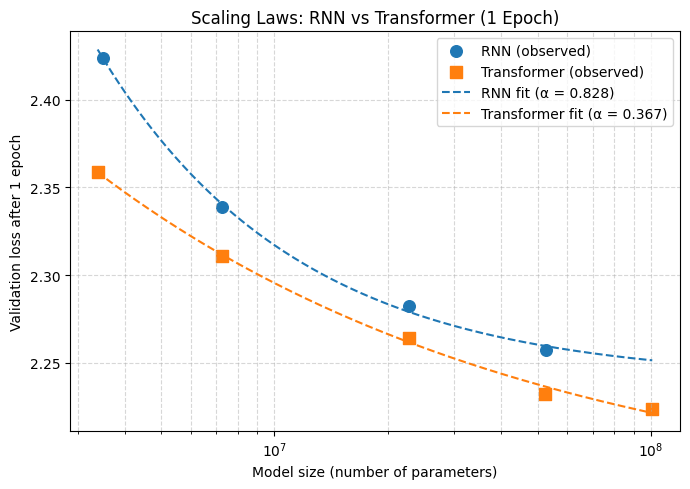

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


def scaling_law(N, a, alpha, c):
    return a * N**(-alpha) + c


N_rnn = np.array([v["params_M"] * 1e6 for v in rnn_results.values()])
L_rnn = np.array([v["val_loss"] for v in rnn_results.values()])


N_tr = np.array([v["params_M"] * 1e6 for v in transformer_results.values()])
L_tr = np.array([v["val_loss"] for v in transformer_results.values()])


p0_rnn = [1.0, 0.05, min(L_rnn)]
p0_tr  = [1.0, 0.05, min(L_tr)]

params_rnn, _ = curve_fit(scaling_law, N_rnn, L_rnn, p0=p0_rnn, maxfev=10000)
params_tr,  _ = curve_fit(scaling_law, N_tr,  L_tr,  p0=p0_tr,  maxfev=10000)

a_rnn, alpha_rnn, c_rnn = params_rnn
a_tr,  alpha_tr,  c_tr  = params_tr

print(f"RNN alpha        = {alpha_rnn:.3f}")
print(f"Transformer alpha = {alpha_tr:.3f}")


N_fit = np.logspace(
    np.log10(min(N_rnn.min(), N_tr.min())),
    np.log10(max(N_rnn.max(), N_tr.max())),
    400
)

L_rnn_fit = scaling_law(N_fit, a_rnn, alpha_rnn, c_rnn)
L_tr_fit  = scaling_law(N_fit, a_tr,  alpha_tr,  c_tr)

plt.figure(figsize=(7, 5))

plt.scatter(N_rnn, L_rnn, s=70, label="RNN (observed)", marker="o")
plt.scatter(N_tr,  L_tr,  s=70, label="Transformer (observed)", marker="s")

plt.plot(
    N_fit, L_rnn_fit, "--",
    label=f"RNN fit (α = {alpha_rnn:.3f})"
)

plt.plot(
    N_fit, L_tr_fit, "--",
    label=f"Transformer fit (α = {alpha_tr:.3f})"
)

plt.xscale("log")
plt.xlabel("Model size (number of parameters)")
plt.ylabel("Validation loss after 1 epoch")
plt.title("Scaling Laws: RNN vs Transformer (1 Epoch)")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
def efficiency_metrics(results_dict):
    params = np.array([v["params_M"] * 1e6 for v in results_dict.values()])
    time = np.array([v["time_min"] for v in results_dict.values()])
    mem = np.array([v["peak_mem_MB"] for v in results_dict.values()])

    time_per_param = time / params
    mem_per_param = mem / params

    return time_per_param.mean(), mem_per_param.mean()

t_time, t_mem = efficiency_metrics(transformer_results)
r_time, r_mem = efficiency_metrics(rnn_results)

print(f"Transformer: time/param = {t_time:.2e} min, mem/param = {t_mem:.2e} MB")
print(f"RNN:         time/param = {r_time:.2e} min, mem/param = {r_mem:.2e} MB")


Transformer: time/param = 2.82e-06 min, mem/param = 7.75e-05 MB
RNN:         time/param = 2.90e-06 min, mem/param = 3.43e-05 MB


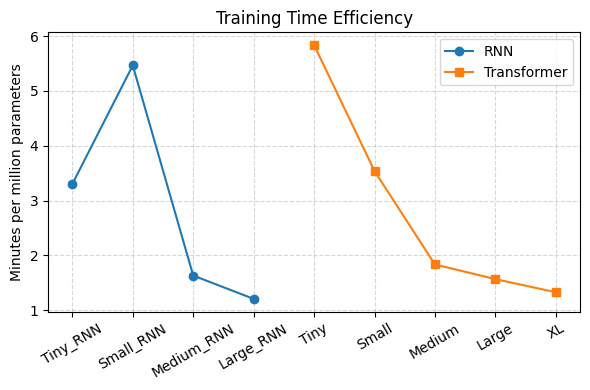

In [ ]:
time_per_M_rnn = np.array([v["time_min"]/v["params_M"] for v in rnn_results.values()])
time_per_M_tr  = np.array([v["time_min"]/v["params_M"] for v in transformer_results.values()])

plt.figure(figsize=(6,4))
plt.plot(rnn_results.keys(), time_per_M_rnn, "o-", label="RNN")
plt.plot(transformer_results.keys(), time_per_M_tr, "s-", label="Transformer")
plt.xticks(rotation=30)
plt.ylabel("Minutes per million parameters")
plt.title("Training Time Efficiency")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


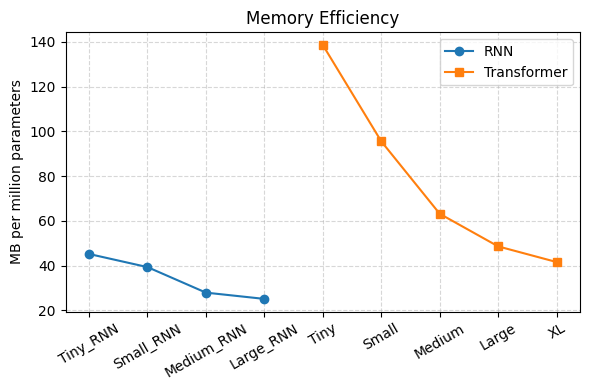

In [ ]:
mem_per_M_rnn = np.array([v["peak_mem_MB"]/v["params_M"] for v in rnn_results.values()])
mem_per_M_tr  = np.array([v["peak_mem_MB"]/v["params_M"] for v in transformer_results.values()])

plt.figure(figsize=(6,4))
plt.plot(rnn_results.keys(), mem_per_M_rnn, "o-", label="RNN")
plt.plot(transformer_results.keys(), mem_per_M_tr, "s-", label="Transformer")
plt.xticks(rotation=30)
plt.ylabel("MB per million parameters")
plt.title("Memory Efficiency")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


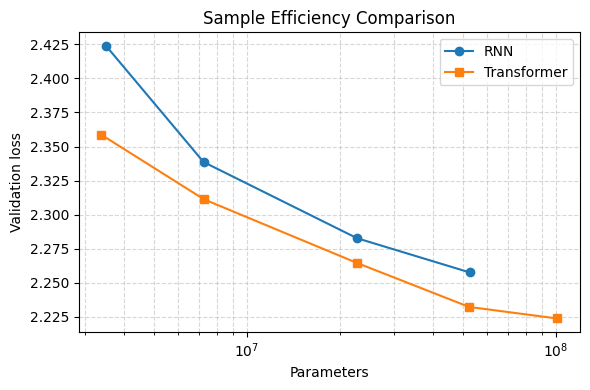

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(N_rnn, L_rnn, "o-", label="RNN")
plt.plot(N_tr,  L_tr,  "s-", label="Transformer")
plt.xscale("log")
plt.xlabel("Parameters")
plt.ylabel("Validation loss")
plt.title("Sample Efficiency Comparison")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()
